<h1 align="center">
<strong>Projet Télédétection Avancée</strong>
</h1>

**Marion BILLY**

**Bretagne 24-25**

> créer un diagramme de flux

# 1. 

### Import des bibliothèques

In [ ]:
import sys
import os
from osgeo import gdal
gdal.UseExceptions()
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# from sklearn.metrics import f1_score

sys.path.append("/home/onyxia/work")
from libsigma import read_and_write as rw
from libsigma import classification as cla
from libsigma import plots

### Définition des chemins

In [2]:
data_path = '/home/onyxia/work/data/projet_eval'
figure_path = '/home/onyxia/work/results/figure'

---

# 2. Analyse des échantillons

## 2.1. Nombre d'échantillons

### 2.1.1 Diagramme en bâton du nombre de polygones par classe

In [13]:
gdf = gpd.read_file(os.path.join(data_path, "PI_strates_bretagne_32630.shp"))
strates = [1, 2, 3, 4]
labels_strates = {1: "Sols Nus", 2: "Herbes", 3: "Landes", 4: "Arbres"}
colors_strates = {1: 'peru', 2: 'goldenrod', 3: 'lightgreen', 4: 'forestgreen'}

# Compter le nombre de polygones par strate
nb_poly = gdf["strate"].value_counts().sort_index()
# Diagramme en bâton
plt.figure()
bars= plt.bar(
    x=[labels_strates[s] for s in nb_poly.index],
    height=nb_poly.values,
    color=[colors_strates[s] for s in nb_poly.index])
# Nombre de polygones au-dessus des barres
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + bar.get_height()*0.01,
        int(bar.get_height()),
        ha='center',)

plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par strate")
plt.tight_layout()

plt.savefig(os.path.join(figure_path, "diag_baton_nb_poly_by_class.png"), dpi=300)
plt.close()

### 2.1.2 Diagramme en bâton du nombre de pixel par classe

#### Rasterisation

On transforme le shapefile des échantillons en raster. Le raster a la même taille et la même résolution spatiale qu'une image Sentinel-2 de référence. Cela permet ensuite d'extraire facilement avec Numpy le nombre de pixels correspondant à chaque strate.

In [21]:
in_vector = os.path.join(data_path, 'PI_strates_bretagne_32630.shp')
ref_image = os.path.join(data_path, 'bretagne_2025-03-31.tif') # une image Sentinel-2 de référence
out_image = os.path.join(data_path, 'PI_strates_bretagne_32630_raster.tif')
field_name = 'strate'  # attribut contenant les classes numériques

# Infos de l'image de référence
ref_image = rw.open_image(ref_image)
nb_lignes, nb_col, _ = rw.get_image_dimension(ref_image)
origin_x, origin_y = rw.get_origin_coordinates(ref_image)
psize_x, psize_y = rw.get_pixel_size(ref_image)

xmin, xmax = origin_x, origin_x + nb_col * psize_x
ymax, ymin = origin_y, origin_y + nb_lignes * psize_y
sptial_res = abs(psize_x)

print("Spatial resolution :", sptial_res)
print("Extent : xmin =", xmin, "ymin =", ymin, "xmax =", xmax, "ymax =", ymax)

# Rasterisation avec GDAL (terminal)
cmd = (
    f"gdal_rasterize -a {field_name} "
    f"-tr {sptial_res} {sptial_res} "
    f"-te {xmin} {ymin} {xmax} {ymax} "
    f"-ot Byte -of GTiff "
    f"{in_vector} {out_image}"
)

os.system(cmd)

Spatial resolution : 10.0
Extent : xmin = 432950.0 ymin = 5362770.0 xmax = 448280.0 ymax = 5368890.0
0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [19]:
roi_raster = os.path.join(data_path, 'PI_strates_bretagne_32630_raster.tif')
strates = [1, 2, 3, 4]
labels_strates = {1: "Sols Nus", 2: "Herbes", 3: "Landes", 4: "Arbres"}
colors_strates = {1: 'peru', 2: 'goldenrod', 3: 'lightgreen', 4: 'forestgreen'}

# Extraire X (valeurs des pixels), Y (labels), t (coordonnées)
_, Y, _ = cla.get_samples_from_roi(roi_raster, roi_raster)

# Compter le nombre de pixels par classe
classes, counts = np.unique(Y, return_counts=True)
nb_pix = pd.Series(counts, index=classes).sort_index()
# Diagramme en bâton
plt.figure()
bars= plt.bar(
    x=[labels_strates[s] for s in nb_pix.index],
    height=nb_pix.values,
    color=[colors_strates[s] for s in nb_pix.index])
# Nombre de pixels au-dessus des barres
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + bar.get_height()*0.01,
        int(bar.get_height()),
        ha='center',)
plt.ylabel("Nombre de pixels")
plt.title("Nombre de pixels par strate")
plt.tight_layout()

plt.savefig(os.path.join(figure_path, "diag_baton_nb_pix_by_class.png"), dpi=300)
plt.close()

### 2.1.3 Comparaison des diagrammes et analyse du déséquilibre des strates

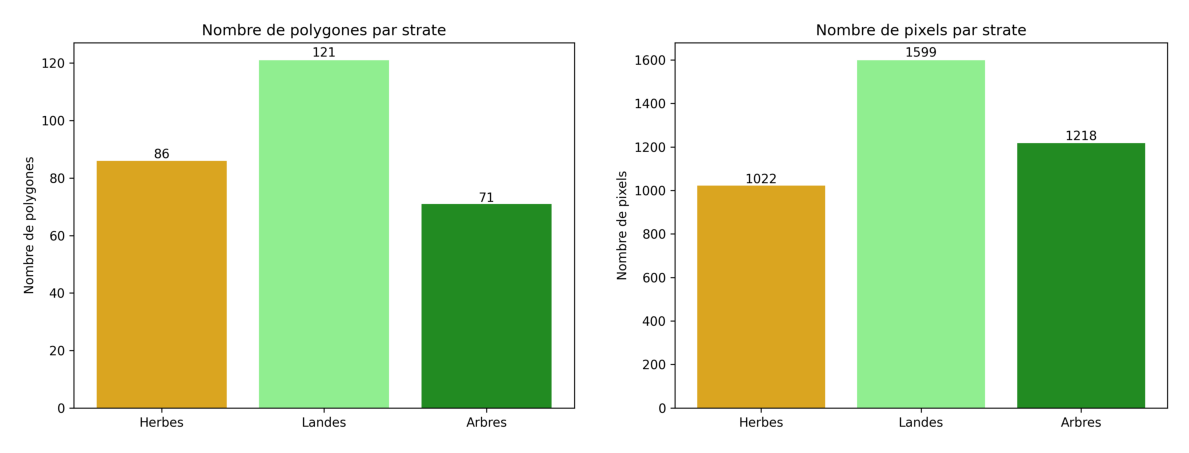

In [20]:
diag_poly = mpimg.imread(os.path.join(figure_path, "diag_baton_nb_poly_by_class.png"))
diag_pix = mpimg.imread(os.path.join(figure_path, "diag_baton_nb_pix_by_class.png"))

# Diagrammes côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].imshow(img_poly)
axes[0].axis('off')
axes[1].imshow(img_pix)
axes[1].axis('off')
plt.tight_layout()

plt.show()


Observations :
- Pas de sols nus dans l'échantillon.
- Landes : la plus représentée (121 polygones, 1599 pixels).
- Arbres : 2ᵉ en nombre de pixels, 3ᵉ en nombre de polygones (71 polygones, 1218 pixels).
- Herbes : 3ᵉ en nombre de pixels, 2ᵉ en nombre de polygones (86 polygones, 1022 pixels).

Ces diagrammes montrent le déséquilibre des strates. On tiendra compte de ces observations dans la classification.


## 2.2. Phénologie des strates, mise en évidence des landes

### 2.2.1 Réorganisation des images Sentinel-2

Les images Sentinel-2 sont initialement fournies sous forme de séries temporelles par bande. Afin de faciliter les analyses ultérieures, les bandes ont été regroupées par date pour produire une image multibande Sentinel-2 par date.

Les 6 bandes correspondent aux 6 dates d’acquisition, et non à des bandes spectrales. Les différentes bandes spectrales sont donc réparties entre plusieurs fichiers (ce qui est cohérent avec leur nom « BXX »), chacun empilant les informations temporelles.

En l'état, le jeu de données fourni n'est pas exploitable car l’organisation des images est différente : chaque fichier correspond à une bande spectrale donnée, dans laquelle est « empilée » la dimension temporelle.

Afin de pouvoir travailler sur ces fichiers, il est donc nécessaire de réorganiser ces données.

Réorganisation des données
On fait l'hypothèse que l'ordre des bandes suit l'ordre chronologique des dates fournies dans l'énoncé, donc :

2025-03-31 → Bande 1
2025-04-10 → Bande 2
2025-05-15 → Bande 3
2025-06-17 → Bande 4
2025-07-12 → Bande 5
2025-08-10 → Bande 6

In [ ]:
bands = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]
dates = ["2025-03-31","2025-04-10","2025-05-15","2025-06-17","2025-07-12","2025-08-10"]

for i, date in enumerate(dates):
    band_arrays = []
    for band in bands:
        filename = os.path.join(data_path, f"bretagne_24-25_{band}.tif")
        arr = rw.load_img_as_array(filename)  # shape = (lignes, colonnes, nb_dates)
        # extraire la bande correspondant à la date i
        single_band = arr[:, :, i]
        # s'assurer que c'est 3D pour write_image
        band_arrays.append(np.atleast_3d(single_band))
    
    # concaténer toutes les bandes pour cette date
    all_bands = np.dstack(band_arrays)  # shape = (lignes, colonnes, nb_bandes)
    
    out_filename = os.path.join(data_path, f"bretagne_{date}.tif")
    rw.write_image(out_filename, all_bands, data_set=rw.open_image(os.path.join(data_path, f"bretagne_24-25_{bands[0]}.tif")))
    print(f"Fichier créé pour {date} -> {out_filename}")

Reconnaître les signatures spectrales et leur évolution temporelle.

On a la liste des images multibandes par date. (B03 → index 1, B05 → index 3)

### 2.2.2 Calcul ARI

L’ARI (Anthocyanin Reflectance Index) est utilisé ici comme indicateur de stress ou de sénescence végétale, permettant de mettre en évidence des différences phénologiques entre strates au cours de la saison de croissance.

In [ ]:
# dossier de travail

dates = [
    "2025-03-31",
    "2025-04-10",
    "2025-05-15",
    "2025-06-17",
    "2025-07-12",
    "2025-08-10"
]

ari_list = []

for date in dates:
    filename = os.path.join(data_dir, f"bretagne_{date}.tif")

    # ouverture
    data_set = rw.open_image(filename)
    img = rw.load_img_as_array(filename)

    # bandes nécessaires
    b03 = img[:, :, 1].astype("float32")
    b05 = img[:, :, 3].astype("float32")

    # masque pixels valides, éviter divisions par zéro
    mask_valid = (b03 > 0) & (b05 > 0)

    # tableau ARI initialisé avec NoData
    ari = np.full(b03.shape, -9999, dtype="float32")

    # calcul ARI uniquement sur pixels valides
    ari[mask_valid] = (
        (1.0 / b03[mask_valid] - 1.0 / b05[mask_valid]) /
        (1.0 / b03[mask_valid] + 1.0 / b05[mask_valid])
    )

    # ajout à la liste pour empilement temporel
    ari_list.append(ari[:, :, np.newaxis])


Empilement temporel

In [ ]:
ari_serie_temp = np.concatenate(ari_list, axis=2)

out_filename = os.path.join(out_path, "ARI_serie_temp.tif")

rw.write_image(
    out_filename,
    ari_serie_temp,
    data_set=data_set,
    gdal_dtype=gdal.GDT_Float32,
)

### 2.2.3. Série temporelle, moyenne et écarts types

In [ ]:

# get_samples_from_roi renvoie X (valeurs ARI), Y (labels), t (coordonnées)
X_samples, Y_samples, _ = cla.get_samples_from_roi("/home/onyxia/work/results/ARI_serie_temp.tif", roi_raster)

# X_samples : valeurs ARI pour les pixels d'échantillons (n_pixels, n_dates)
# Y_samples : labels des strates correspondants (n_pixels,)

# convertir en DataFrame
df = pd.DataFrame(X_samples, columns=dates)
df['strate'] = Y_samples.flatten()

# remplacer NoData par NaN
df.replace(-9999, np.nan, inplace=True)

# moyenne et écart-type par strate
grouped = df.groupby('strate')
mean_df = grouped.mean()
std_df = grouped.std()



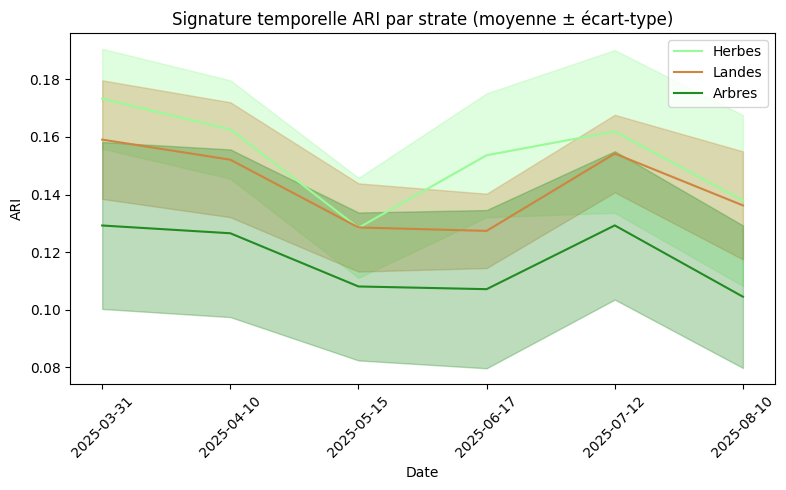

In [ ]:
# couleurs et labels pour les strates
colors = {2: 'palegreen', 3: 'peru', 4: 'forestgreen'}
labels_name = {2: 'Herbes', 3: 'Landes', 4: 'Arbres'}

fig, ax = plt.subplots(figsize=(8,5))

for strate in mean_df.index:
    means = mean_df.loc[strate].values
    stds = std_df.loc[strate].values
    ax.plot(range(len(dates)), means, color=colors[strate], label=labels_name[strate])
    ax.fill_between(
        range(len(dates)),
        means - stds,
        means + stds,
        color=colors[strate],
        alpha=0.3
    )

ax.set_xticks(range(len(dates)))
ax.set_xticklabels(dates, rotation=45)
ax.set_xlabel("Date")
ax.set_ylabel("ARI")
ax.set_title("Signature temporelle ARI par strate (moyenne ± écart-type)")
ax.legend()
plt.tight_layout()

fig_dir = os.path.join(figure_path, "figure")
os.makedirs(fig_dir, exist_ok=True)
plt.savefig(os.path.join(fig_dir, "ARI_signature_by_strate.png"), dpi=300)
plt.show()




Si la courbe des landes est distincte dans le temps des autres strates, surtout à certaines dates (ex. pic automnal dû aux anthocyanes), alors on peut dire que le ARI permet de distinguer la lande.

Sinon, elle se confond avec d’autres classes et ARI seul ne suffit pas.

Les landes ne sont pas très distinctes

---

# 3. Production d’une carte de strates à l’échelle du pixel

CLIP EMPRISE, ECHANTILLONS DEPASSENT
finalement plutôt un pb d'ARI?

ref_data = ds.GetRasterBand(1).ReadAsArray()  # pour le masque NoData/NaN

img = np.zeros((nb_row, nb_col, 1), dtype="uint8")
img[t_img[0], t_img[1], 0] = Y_pred

Masque : zones sans donnée dans l’image de référence
img[np.isnan(ref_data), 0] = 0

Produire une carte spatiale des strates de végétation (Sol nu / Herbe / Landes / Arbres) à partir des images Sentinel-2, puis évaluer la qualité de la classification à l’aide des échantillons terrain.

Préparer les données pour la classification

In [ ]:
# Liste de toutes les images multibandes par date
stack_list = []

for date in dates:
    img_file = os.path.join(data_dir, f"bretagne_{date}.tif")
    img = rw.load_img_as_array(img_file)  # shape = lignes x colonnes x nb_bandes
    stack_list.append(img)

# Ajouter ARI
ari_file = os.path.join(out_path, "ARI_serie_temp.tif")
ari_img = rw.load_img_as_array(ari_file)  # shape = lignes x colonnes x n_dates
stack_list.append(ari_img)

# Concaténation sur la 3e dimension (toutes les variables)
full_stack = np.dstack(stack_list)  # shape = lignes x colonnes x n_variables
print("Full stack shape:", full_stack.shape)

Full stack shape: (612, 1533, 66)


## 3.1. Choix du classifieur et sa paramètrisation

Pour la classification supervisée des strates, nous avons choisi le classifieur RandomForestClassifier de la bibliothèque scikit-learn.
Cette méthode repose sur l’assemblage de multiples arbres de décision et permet de limiter le sur-apprentissage tout en conservant une grande capacité d’apprentissage.
Les variables explicatives utilisées correspondent à l’empilement temporel des bandes Sentinel-2 ainsi que des indices ARI calculés pour chaque date.
L’optimisation des hyperparamètres du classifieur a été réalisée via une recherche sur grille (GridSearchCV) afin d’identifier la combinaison qui maximise la capacité du modèle à généraliser aux données non vues.

Le déséquilibre numérique entre les classes justifie techniquement l'usage du StratifiedGroupKFold. Cette méthode assure que chaque classe, même minoritaire, est représentée de manière équitable lors de la validation croisée, garantissant ainsi la fiabilité des scores de précision finaux.

Extraire X et Y pour les pixels d’échantillon

In [ ]:
full_stack_file = os.path.join(out_path, "full_stack.tif")
rw.write_image(full_stack_file, full_stack, data_set=data_set)  # data_set = Sentinel de référence

# Extraire X et Y depuis le fichier raster
X, Y, _ = cla.get_samples_from_roi(full_stack_file, roi_raster)

# Remplacer NoData si nécessaire
X = np.nan_to_num(X, nan=-9999)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

Y = Y.ravel()  # transforme (3839,1) → (3839,)

X shape: (3839, 66)
Y shape: (3839, 1)


Split train/test et validation croisée

Optimisation des hyperparamètres avec RF

RF sensible au déséquilibre de classes

On utilise stratify=Y dans le split pour préserver la proportion des classes.

f1_weighted prend en compte le déséquilibre de classes.

Après GridSearch, tu peux examiner l’importance des variables via best_model.feature_importances_ pour voir quelles bandes ou dates sont les plus discriminantes.

Évaluer le modèle final sur le jeu de test

In [ ]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)

# Définir la grille des hyperparamètres à tester
param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [10, 15, 20, None],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 5]
}

# Créer le classifieur RF
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV avec validation croisée à 5 plis et métrique F1 pondérée
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_weighted",# métrique adaptée aux classes déséquilibrées
    n_jobs=-1
    return_train_score=True
)

# Lancer l’optimisation
grid_search.fit(X_train, y_train)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (1049293305.py, line 27)

## 3.2. Stratégie de validation

In [ ]:
# Récupérer le meilleur modèle
best_model = grid_search.best_estimator_
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleure F1-weighted CV :", grid_search.best_score_)
print(f"F1 CV moyen : {grid_search.best_score_:.3f}")

# Écart-type des scores CV
cv_results = pd.DataFrame(grid_search.cv_results_)
best_index = grid_search.best_index_
print(f"Écart-type CV du meilleur modèle : {cv_results.loc[best_index,'std_test_score']:.3f}")

# Évaluation sur le jeu de test
y_pred = best_model.predict(X_test)
print("Classification report sur test set :")
print(classification_report(y_test, y_pred))
# Compute the quality metrics by classe.
report_str = classification_report(y_test, y_pred, labels=np.unique(y_test))#, output_dict=True)

cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(cm)
print(type(cm))

# Compute the overall accuracy
accuracy = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy test : {accuracy:.3f}")
print(f"F1 test : {f1_test:.3f}")
print("\nRapport de classification :\n", classification_report(y_test, y_pred, target_names=strates))


Meilleurs hyperparamètres : {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 300}
Meilleure F1-weighted CV : 0.9721517119827393
F1 CV moyen : 0.972
Écart-type CV du meilleur modèle : 0.006
Classification report sur test set :
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       307
           3       0.97      0.98      0.98       480
           4       0.98      0.97      0.97       365

    accuracy                           0.98      1152
   macro avg       0.98      0.98      0.98      1152
weighted avg       0.98      0.98      0.98      1152

Matrice de confusion :
[[301   6   0]
 [  0 471   9]
 [  1   9 355]]
<class 'numpy.ndarray'>
Accuracy test : 0.978
F1 test : 0.978


NameError: name 'strates' is not defined

In [ ]:
# Récupérer les résultats complets de GridSearchCV
cv_results = grid_search.cv_results_
# Créer un DataFrame avec uniquement les colonnes utiles
df_results = pd.DataFrame({
    'n_estimators': cv_results['param_n_estimators'],
    'max_depth': cv_results['param_max_depth'],
    'max_features': cv_results.get('param_max_features', None),  # si tu as ce paramètre
    'min_samples_leaf': cv_results.get('param_min_samples_leaf', None),
    'mean_test_score': cv_results['mean_test_score'],
    'std_test_score': cv_results['std_test_score'],
    'rank_test_score': cv_results['rank_test_score']
})
# Afficher les 10 meilleures combinaisons
df_results.sort_values('rank_test_score').head(10)

,n_estimators,max_depth,max_features,min_samples_leaf,mean_test_score,std_test_score,rank_test_score
24,300,None,log2,1,0.972152,0.006299,1
114,300,20,log2,1,0.972152,0.006299,1
84,300,15,log2,1,0.971781,0.006342,3
81,100,15,log2,1,0.971766,0.006863,4
111,100,20,log2,1,0.971014,0.005920,5
21,100,None,log2,1,0.971014,0.005920,5
83,200,15,log2,1,0.970657,0.005664,7
23,200,None,log2,1,0.970281,0.005627,8
113,200,20,log2,1,0.970281,0.005627,8
112,150,20,log2,1,0.969532,0.005074,10


Matrice de confusion

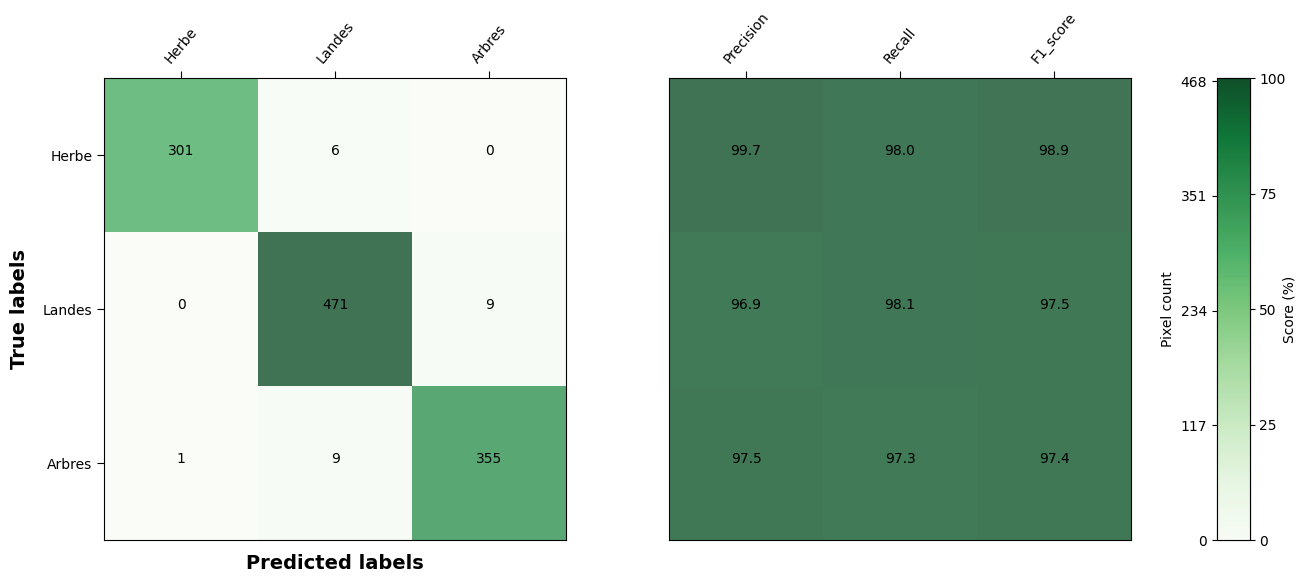

In [ ]:
plots.plot_cm(cm, labels=['Herbe', 'Landes', 'Arbres'])

Qualité des classes

In [ ]:
report = classification_report(y_test, y_pred, labels=np.unique(y_test), output_dict=True)
# Affiche tout le dictionnaire
print(report)
print()

report_df = pd.DataFrame.from_dict(report)
report_df

# keep columns
report_df = report_df.loc[:, ['2', '3', '4']]
# drop rows (axis=0, same as numpy)
report_df = report_df.drop(['support'], axis=0)
report_df

{'2': {'precision': 0.9966887417218543, 'recall': 0.9804560260586319, 'f1-score': 0.9885057471264368, 'support': 307.0}, '3': {'precision': 0.9691358024691358, 'recall': 0.98125, 'f1-score': 0.9751552795031055, 'support': 480.0}, '4': {'precision': 0.9752747252747253, 'recall': 0.9726027397260274, 'f1-score': 0.9739368998628258, 'support': 365.0}, 'accuracy': 0.9782986111111112, 'macro avg': {'precision': 0.9803664231552385, 'recall': 0.9781029219282198, 'f1-score': 0.9791993088307893, 'support': 1152.0}, 'weighted avg': {'precision': 0.9784235274471086, 'recall': 0.9782986111111112, 'f1-score': 0.9783270546694776, 'support': 1152.0}}



,2,3,4
precision,0.996689,0.969136,0.975275
recall,0.980456,0.981250,0.972603
f1-score,0.988506,0.975155,0.973937


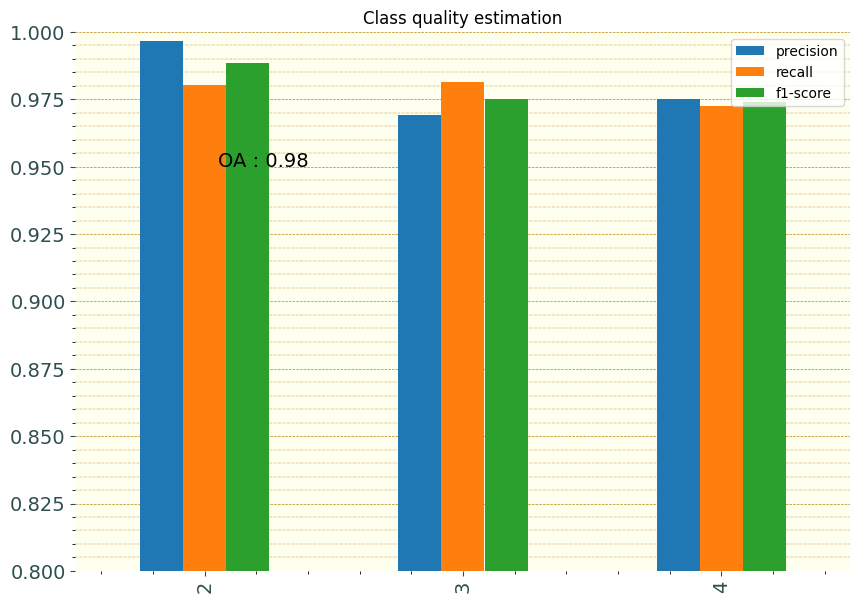

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax = report_df.T.plot.bar(ax=ax, zorder=2)

# custom : information
ax.set_ylim(0.8, 1)
ax.text(0.05, 0.95, 'OA : {:.2f}'.format(accuracy), fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
                      linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
                      linewidth=0.3, zorder=1)

Ajouter la barre d'erreurs

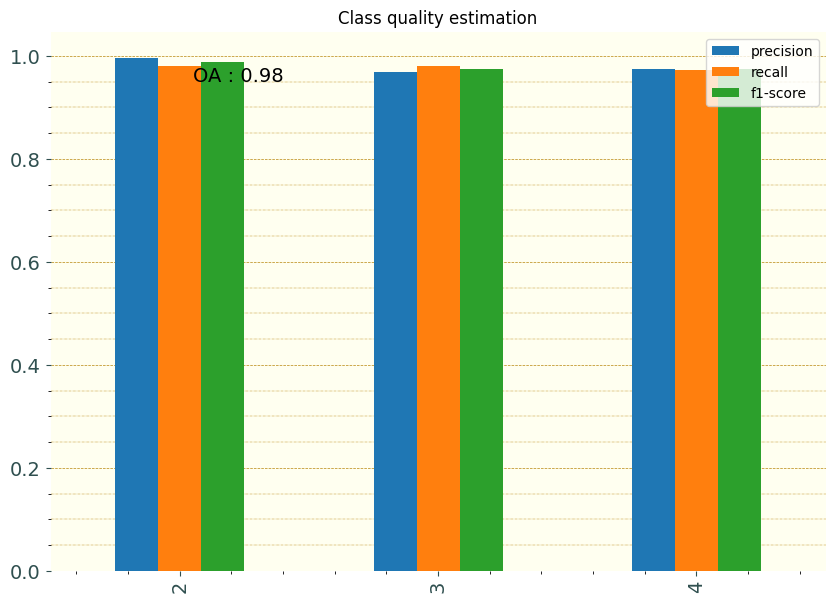

In [ ]:
plots.plot_class_quality(report, accuracy) #out_filename=out_qualite

### 3. Contribution des variables

In [ ]:
# Contribution des variables
contributions = best_model.feature_importances_

# Noms des variables : toutes les bandes pour chaque date + ARI
band_names = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]
ari_dates = dates
features = [f"{band}_{date}" for date in dates for band in band_names] + [f"ARI_{date}" for date in dates]

# dataframe
df_contributions = pd.DataFrame({
    "feature": features,
    "contribution": contributions
})

# trier par contribution
df_contributions.sort_values("contribution", ascending=False, inplace=True)

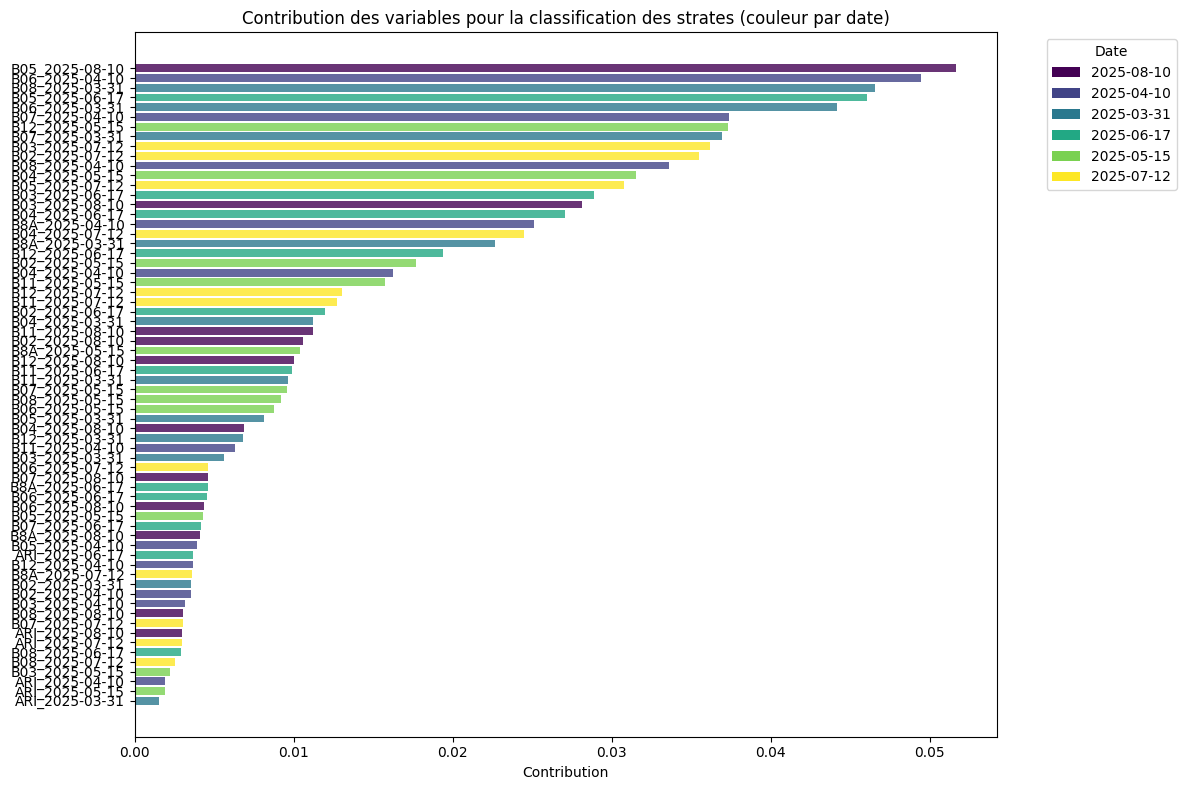

In [ ]:
#import matplotlib.cm as cm
#import matplotlib.colors as mcolors

# extraire la date depuis le nom des features
df_contributions["date"] = df_contributions["feature"].apply(lambda x: x.split("_")[1])

# créer une palette de couleurs pour les dates
unique_dates = df_contributions["date"].unique()
colors = cm.viridis(np.linspace(0, 1, len(unique_dates)))  # tu peux changer "viridis" par "tab10", "plasma", etc.
date_color_map = dict(zip(unique_dates, colors))

# couleur pour chaque barre
bar_colors = df_contributions["date"].map(date_color_map)

plt.figure(figsize=(12,8))
plt.barh(
    df_contributions["feature"], 
    df_contributions["contribution"], 
    color=df_contributions["date"].map(date_color_map), 
    alpha=0.8
)
plt.xlabel("Contribution")
plt.title("Contribution des variables pour la classification des strates (couleur par date)")
plt.gca().invert_yaxis()

# légende
#from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=date_color_map[d], label=d) for d in unique_dates]
plt.legend(handles=legend_elements, title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


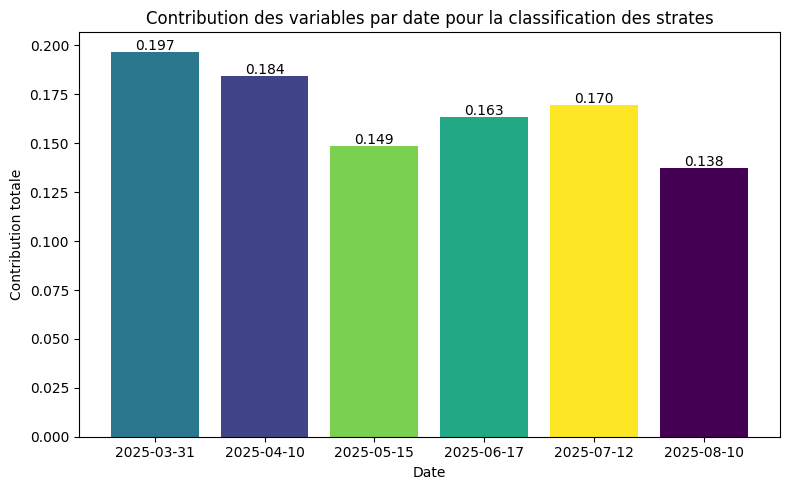

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(
    contrib_par_date.index, 
    contrib_par_date.values, 
    color=[date_color_map[d] for d in contrib_par_date.index]
)
plt.ylabel("Contribution totale")
plt.xlabel("Date")
plt.title("Contribution des variables par date pour la classification des strates")

# ajouter les valeurs
for i, v in enumerate(contrib_par_date.values):
    plt.text(i, v + 0.001, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()

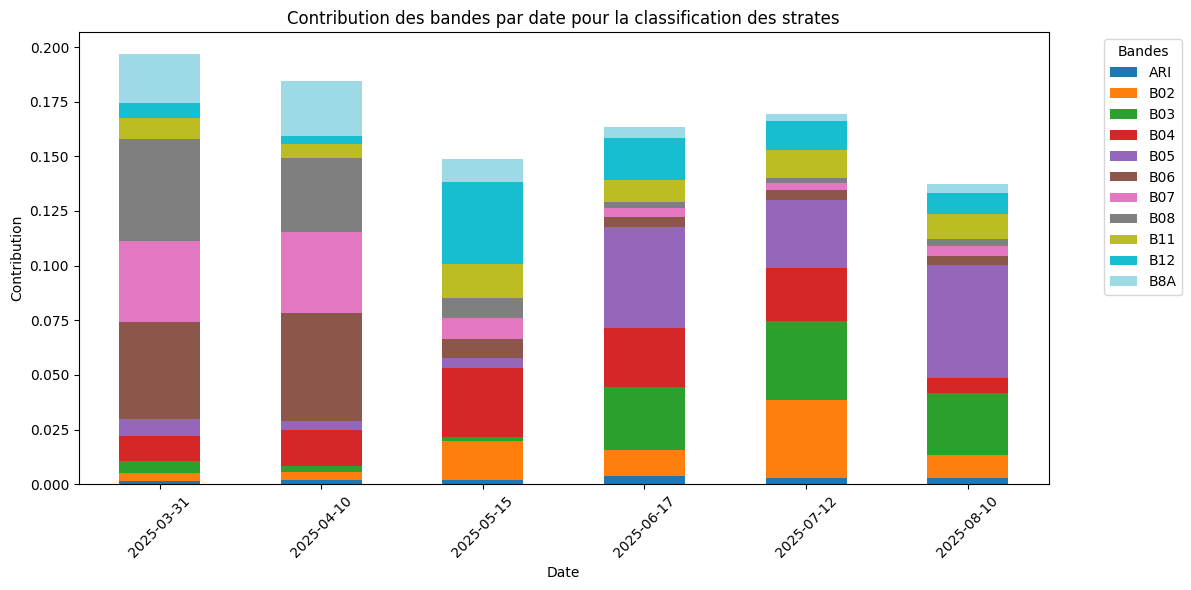

In [ ]:
pivot_df = df_contributions.pivot_table(index="date", columns="band", values="contribution", aggfunc="sum")
pivot_df.plot(
    kind="bar", 
    stacked=True, 
    figsize=(12,6), 
    colormap="tab20"  # couleurs différentes pour chaque bande
)
plt.ylabel("Contribution")
plt.xlabel("Date")
plt.title("Contribution des bandes par date pour la classification des strates")
plt.xticks(rotation=45)
plt.legend(title="Bandes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

---

# 4. Production des cartes finales

In [ ]:
# -----------------------------
# 1. Charger les données empilées
# -----------------------------
full_stack_file = os.path.join(out_path, "full_stack.tif")
img_stack = rw.load_img_as_array(full_stack_file)  # shape: lignes x colonnes x n_features

# récupérer dimensions
n_rows, n_cols, n_features = img_stack.shape

# -----------------------------
# 2. Préparer les données pour la prédiction
# -----------------------------
X_pred = img_stack.reshape(-1, n_features)  # transformer en n_pixels x n_features
X_pred = np.nan_to_num(X_pred, nan=-9999)   # remplacer les NoData si nécessaire

# -----------------------------
# 3. Prédire avec le modèle optimisé
# -----------------------------
y_pred_flat = best_model.predict(X_pred)

# -----------------------------
# 4. Reshape pour revenir à la taille d'origine
# -----------------------------
y_pred_raster = y_pred_flat.reshape(n_rows, n_cols)

# -----------------------------
# 5. Fixer le NoData et type uint8
# -----------------------------
y_pred_raster = y_pred_raster.astype(np.uint8)
y_pred_raster[y_pred_raster == 0] = 0  # nodata = 0

# -----------------------------
# 6. Sauvegarder la carte finale
# -----------------------------
carte_file = os.path.join(out_path, "carte_strates.tif")
rw.write_image(
    carte_file,
    y_pred_raster,
    data_set=rw.open_image(full_stack_file),
    gdal_dtype=gdal.GDT_Byte
)

print("Carte des strates produite :", carte_file)

Carte des strates produite : /home/onyxia/work/results/carte_strates.tif


---

# 5. Analyse des résultats

In [ ]:
# extraire X et Y pour les échantillons
X_test_samples, Y_test_samples, _ = cla.get_samples_from_roi(full_stack_file, roi_raster)
X_test_samples = np.nan_to_num(X_test_samples, nan=-9999)
Y_test_samples = Y_test_samples.ravel()

# prédiction sur les échantillons
Y_pred_samples = best_model.predict(X_test_samples)

# rapport
print(classification_report(Y_test_samples, Y_pred_samples))
print(confusion_matrix(Y_test_samples, Y_pred_samples))


              precision    recall  f1-score   support

           2       1.00      0.99      1.00      1022
           3       0.99      0.99      0.99      1599
           4       0.99      0.99      0.99      1218

    accuracy                           0.99      3839
   macro avg       0.99      0.99      0.99      3839
weighted avg       0.99      0.99      0.99      3839

[[1016    6    0]
 [   0 1590    9]
 [   1    9 1208]]


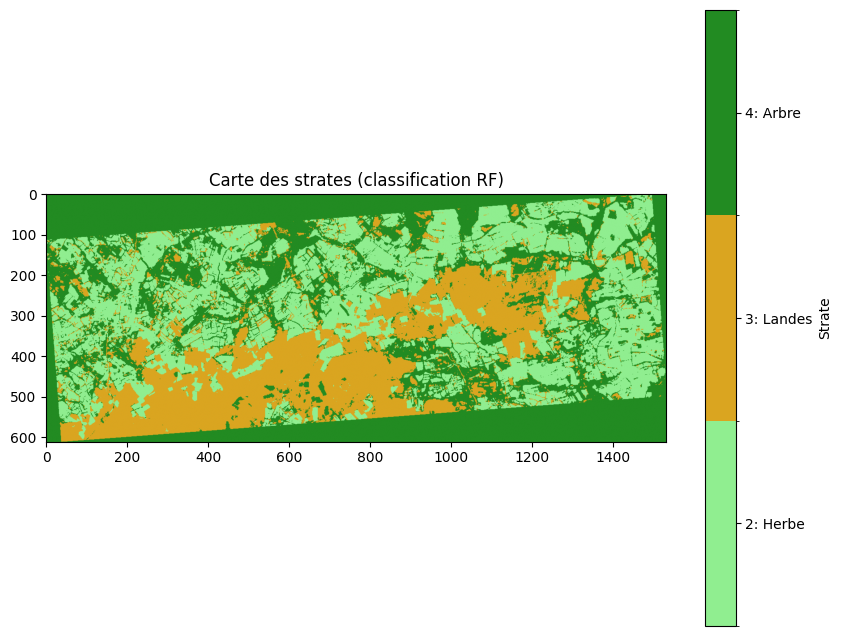

In [ ]:
#from matplotlib.colors import ListedColormap, BoundaryNorm

# Classes discrètes
classes = [2, 3, 4]

# Couleurs correspondantes
colors = ['lightgreen', 'goldenrod', 'forestgreen']

# Créer colormap et normalisation pour classes discrètes
cmap = ListedColormap(colors)
norm = BoundaryNorm([1.5, 2.5, 3.5, 4.5], cmap.N)  # bornes pour 2,3,4

plt.figure(figsize=(10,8))
im = plt.imshow(y_pred_raster, cmap=cmap, norm=norm)
cbar = plt.colorbar(im, ticks=classes)
cbar.set_label('Strate')
cbar.ax.set_yticklabels(['2: Herbe', '3: Landes', '4: Arbre'])  # optionnel : nom des classes
plt.title("Carte des strates (classification RF)")
plt.show()

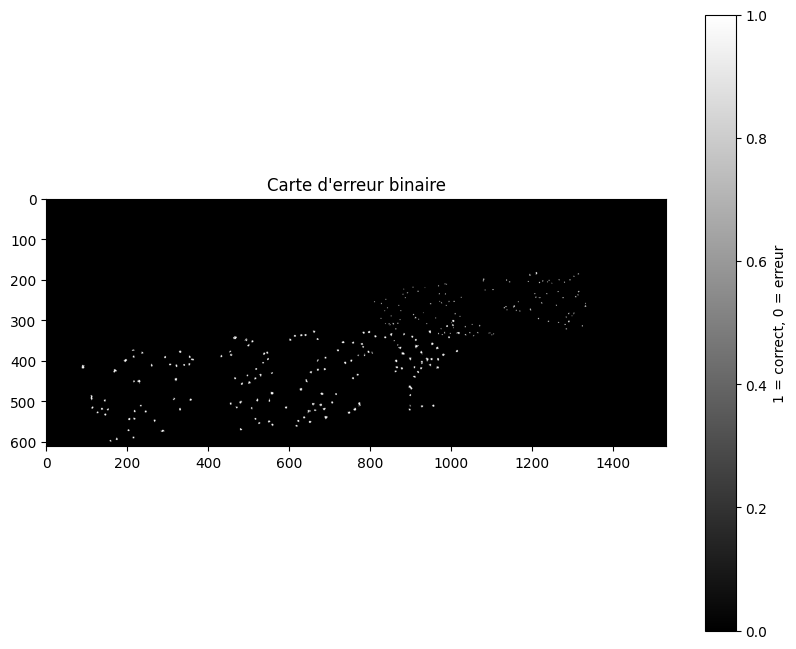

In [ ]:
# INVERSE
# 
# S'assurer que les rasters sont 2D
Y_raster = np.squeeze(Y_raster)        # supprime l'axe singleton si existant
y_pred_raster = np.squeeze(y_pred_raster)

# Créer la carte d'erreur binaire
error_map = np.zeros_like(Y_raster, dtype=np.uint8)

# Pixels valides : Y_raster != 0
valid_mask = Y_raster != 0

# Correct = 1, erreur = 0
error_map[valid_mask] = (y_pred_raster[valid_mask] == Y_raster[valid_mask]).astype(np.uint8)

# Affichage
plt.figure(figsize=(10,8))
cmap = plt.cm.gray  # 0 = erreur, 1 = correct
plt.imshow(error_map, cmap=cmap)
plt.colorbar(label='1 = correct, 0 = erreur')
plt.title("Carte d'erreur binaire")
plt.show()


afficher dans img RGB + couleur par classes